In [1]:
import pandas as pd
df = pd.read_csv("/Users/ellise/Desktop/untitled folder 2/df00.csv")
df.drop("Unnamed: 0",axis = 1).head(5)

,VernacularNameCategory,latitude,longitude,DepthInMeters,Oxygen,Salinity,Temperature,Phosphate,LocationAccuracy,Station_-,...,SamplingEquipment_submersible,SamplingEquipment_towed camera,SamplingEquipment_trawl,RecordType_NaN,RecordType_catch record,RecordType_literature,RecordType_notation,RecordType_specimen,RecordType_still image,RecordType_video observation
0,2,36.87485,-121.92476,48.0,5.605830,33.207511,11.375480,0.874281,100.0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,25.88676,-167.78026,2000.0,1.469286,34.564939,2.561229,3.166553,50.0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,37.36785,-123.39338,1294.0,0.896997,34.496119,3.085411,3.205367,100.0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,51.50220,-177.92657,1078.0,0.506452,34.402537,3.266718,3.181331,20.0,0,...,0,0,0,0,0,0,0,0,0,1
4,7,29.06941,-88.37699,404.0,0.902513,34.207603,7.068033,2.990354,50.0,0,...,0,0,0,1,0,0,0,0,0,0


In [2]:
import numpy as np
X = np.array(df.drop(['VernacularNameCategory'],axis=1))
Y = np.array(df["VernacularNameCategory"])
Y = Y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', Y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

('Train data shape: ', (6183, 1191))
('Train labels shape: ', (6183,))
('Test data shape: ', (1092, 1191))
('Test labels shape: ', (1092,))


In [3]:
import torch
from torch.autograd import Variable

a = torch.from_numpy(X_test)
b = torch.from_numpy(Y_test)

In [6]:
dtype = torch.FloatTensor
a = a.type(dtype)
c = a.view(-1,1191,1)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1191, 1191, 1) # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv1d(1191, 1191, 1)
        self.fc1   = nn.Linear(1191, 800) # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(800, 400)
        self.fc3   = nn.Linear(400, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # Max pooling over a (2, 2) window z 特征减一半
        x = F.relu(self.conv2(x)) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

x = Variable(c)
y = Variable(b, requires_grad=False)

# Construct our model by instantiating the class defined above
model = Net()
all_losses = []
# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
for t in range(100):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    all_losses.append(loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

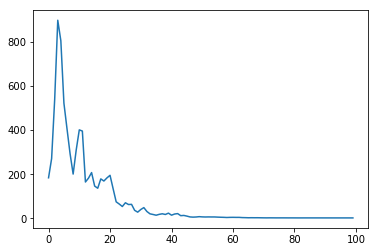

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)

In [9]:
topk_n, topk_i = model(x).data.topk(1)
count = 0
for i in xrange(Y_test.size):
    if topk_i[i][0] == Y_test[i]:
        count+=1

print(float(count)/float(Y_test.size))

0.28021978022


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
download = False  # download MNIST dataset or not

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print '==>>> total trainning batch number: {}'.format(len(train_loader))
print '==>>> total testing batch number: {}'.format(len(test_loader))


==>>> total trainning batch number: 600
==>>> total testing batch number: 100


In [2]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

('X_train:', torch.Size([100, 1, 28, 28]), 'type:', 'torch.FloatTensor')
('y_train:', torch.Size([100]), 'type:', 'torch.LongTensor')


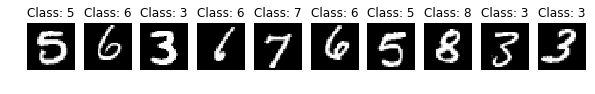

In [52]:
import matplotlib.pyplot as plt
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

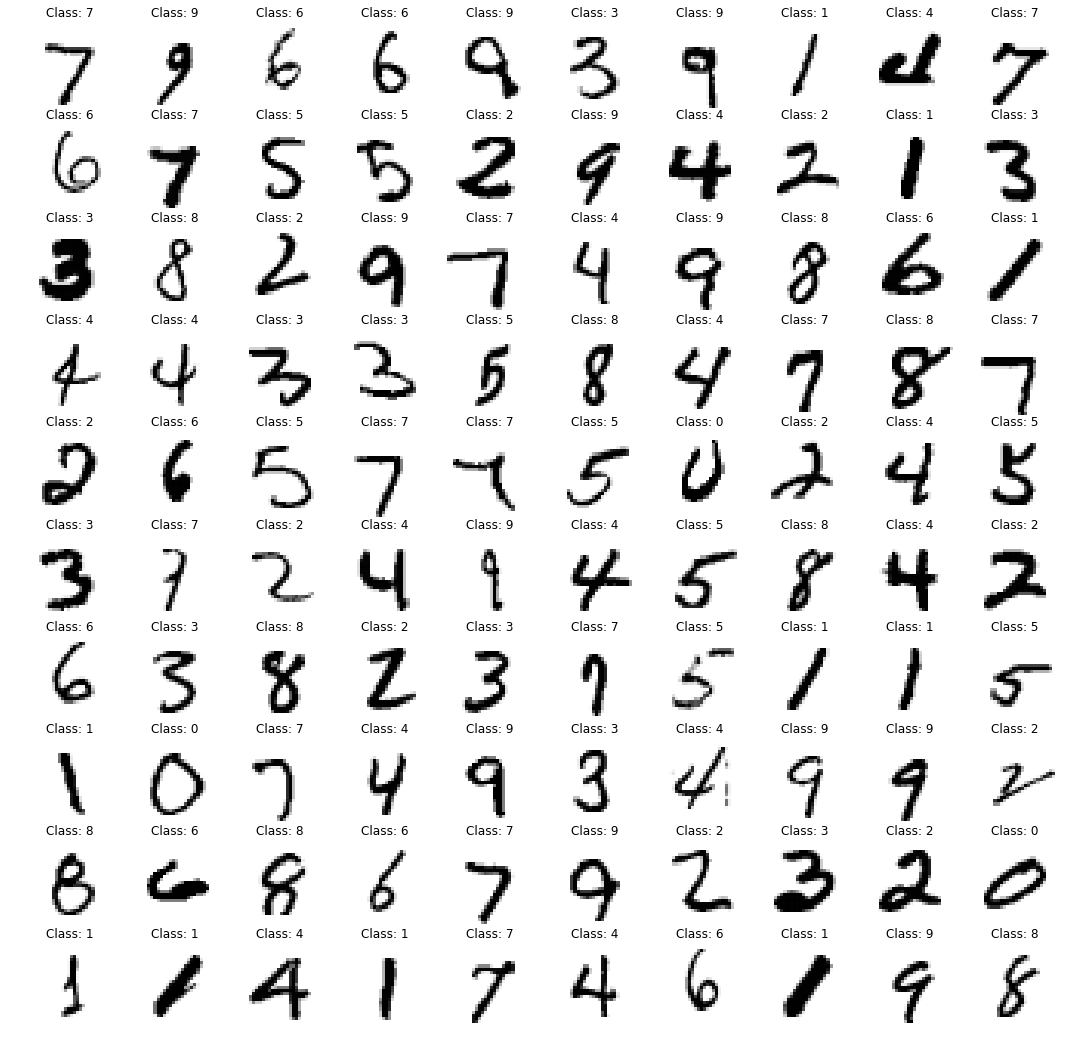

In [4]:
unloader = transforms.ToPILImage()
fig, axarr = plt.subplots(10,10)
fig.set_size_inches(18.5, 18.5)
y_axis = -1
for batch_idx, (x,y) in enumerate(test_loader):
    if batch_idx % 10 == 0:
        y_axis += 1
    x_axis = batch_idx - 10*y_axis    
    image = x[0].numpy().reshape(28,28)
    axarr[x_axis, y_axis].imshow(image, cmap = "gray_r")
    axarr[x_axis, y_axis].set_title("Class: {}".format(y[0]))
    axarr[x_axis, y_axis].axis('off')

1.epoch: Even though loss could be no more dropping down as epoch increases, the accuracy on test-set still goes up.

2.momentum: Hight momentum(tuned from 0.5 up to 0.9) helps converg and reduce final loss hence increases accuracy with same epoch.

3.hidden layers: 250 hidden layers perform better than 50 layers, but with more hidden layers, it didn't work better as expected. appropriate is best(avoid overfitting)

4.Dropout can avoid overfitting so that increases accuracy on test-set.

In [51]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        nn.init.xavier_uniform(self.fc1.weight)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500, 256)
        nn.init.xavier_uniform(self.fc2.weight)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256,10)
        nn.init.xavier_uniform(self.fc3.weight)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
all_losses = []
criteria = nn.CrossEntropyLoss()
model_MLP = MLPNet()
optimizer = optim.SGD(model_MLP.parameters(), lr=0.01, momentum=0.9)
schedule = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)
log_interval=100
for epoch in range(8):
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        y_pred = model_MLP(data)
        loss = criteria(y_pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            all_losses.append(loss.data[0])
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.428722
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.545448
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.384614
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.441916
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.313257
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.258275
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.260633
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.341018
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.307763
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.182159
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.250714
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.182763
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.151707
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.179356
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.102993
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.233324
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.234062
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.051113
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.194760
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.091470
Train Epoch: 3 [2000

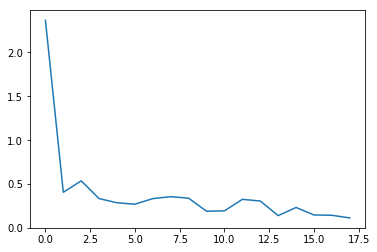

In [49]:
plt.figure()
plt.plot(all_losses)

In [50]:
count = 0
validate_data = test_loader

if validate_data == test_loader:
    flag = "Test Set"
if validate_data == train_loader:
    flag = "Train Set"
for batch_idx, (x,y) in enumerate(validate_data):
    x= Variable(x)
    topk_n, topk_i = model_MLP(x).data.topk(1)
    for i in xrange(batch_size):
        if topk_i[i][0] == y[i]:
            count+=1

print('accuracy of MLPNet: {}% on {}'.format(100*float(count)/float(batch_size*len(validate_data)),flag))

accuracy of MLPNet: 95.33% on Test Set


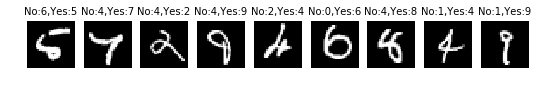

In [27]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

count = 0
validate_data = test_loader
for batch_idx, (x,y) in enumerate(validate_data):
    xv= Variable(x)
    topk_n, topk_i = model_MLP(xv).data.topk(1)
    for i in xrange(batch_size):
        if (topk_i[i][0] != y[i]) & (count < 9):
            count +=1 
            plt.subplot(1,10,count)
            plt.axis('off')
            image = x[i].numpy().reshape(28,28)
            plt.imshow(image, cmap="gray")
            plt.title("No:{},Yes:{}".format(topk_i[i][0],y[i]),fontsize=10)

In [29]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        nn.init.xavier_uniform(self.conv1.weight)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        nn.init.xavier_uniform(self.conv2.weight)
        self.fc1 = nn.Linear(4*4*50, 500)
        nn.init.xavier_uniform(self.fc1.weight)
        self.fc2 = nn.Linear(500, 10)
        nn.init.xavier_uniform(self.fc2.weight)
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)
all_losses = []
log_interval = 100
criteria = nn.CrossEntropyLoss()
model_LeNet = LeNet()
optimizer = optim.SGD(model_LeNet.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10):
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        y_pred = model_LeNet(data)
        loss = criteria(y_pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            all_losses.append(loss.data[0])
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314170
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.284860
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.270018
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.111421
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.093109
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.045942
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.052974
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.047702
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.066122
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.054243
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.092491
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.055726
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.004862
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.054499
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.047419
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.038369
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.028681
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.030995
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.003341
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.037623
Train Epoch: 3 [2000

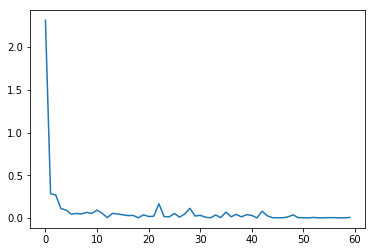

In [30]:
plt.figure()
plt.plot(all_losses)

In [31]:
count = 0
validate_data = test_loader
for batch_idx, (x,y) in enumerate(validate_data):
    x= Variable(x)
    topk_n, topk_i = model_LeNet(x).data.topk(1)
    for i in xrange(batch_size):
        if topk_i[i][0] == y[i]:
            count+=1

print('accuracy of LeNetNet: {}%'.format(100*float(count)/float(batch_size*len(validate_data))))

accuracy of LeNetNet: 99.07%


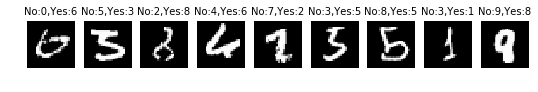

In [32]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

count = 0
validate_data = test_loader
for batch_idx, (x,y) in enumerate(validate_data):
    xv= Variable(x)
    topk_n, topk_i = model_LeNet(xv).data.topk(1)
    for i in xrange(batch_size):
        if (topk_i[i][0] != y[i]) & (count < 9):
            count +=1 
            plt.subplot(1,10,count)
            plt.axis('off')
            image = x[i].numpy().reshape(28,28)
            plt.imshow(image, cmap="gray")
            plt.title("No:{},Yes:{}".format(topk_i[i][0],y[i]),fontsize=10)